In [ ]:
"""##   **SPAM DETECTOR PROJECT**"""


In [1]:
!pip install transformers


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


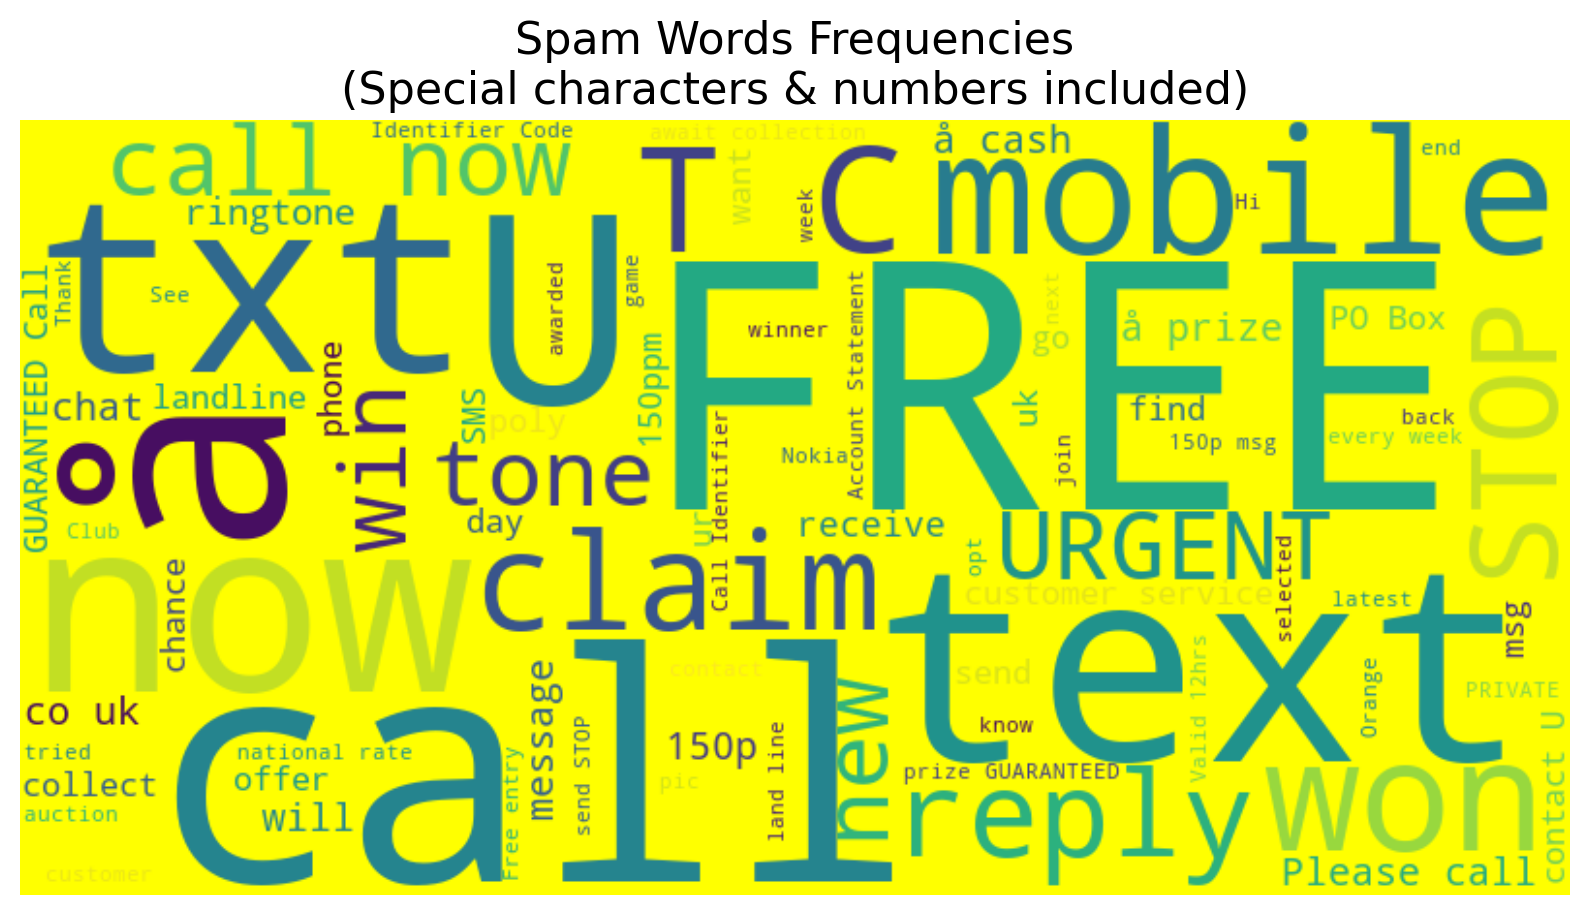

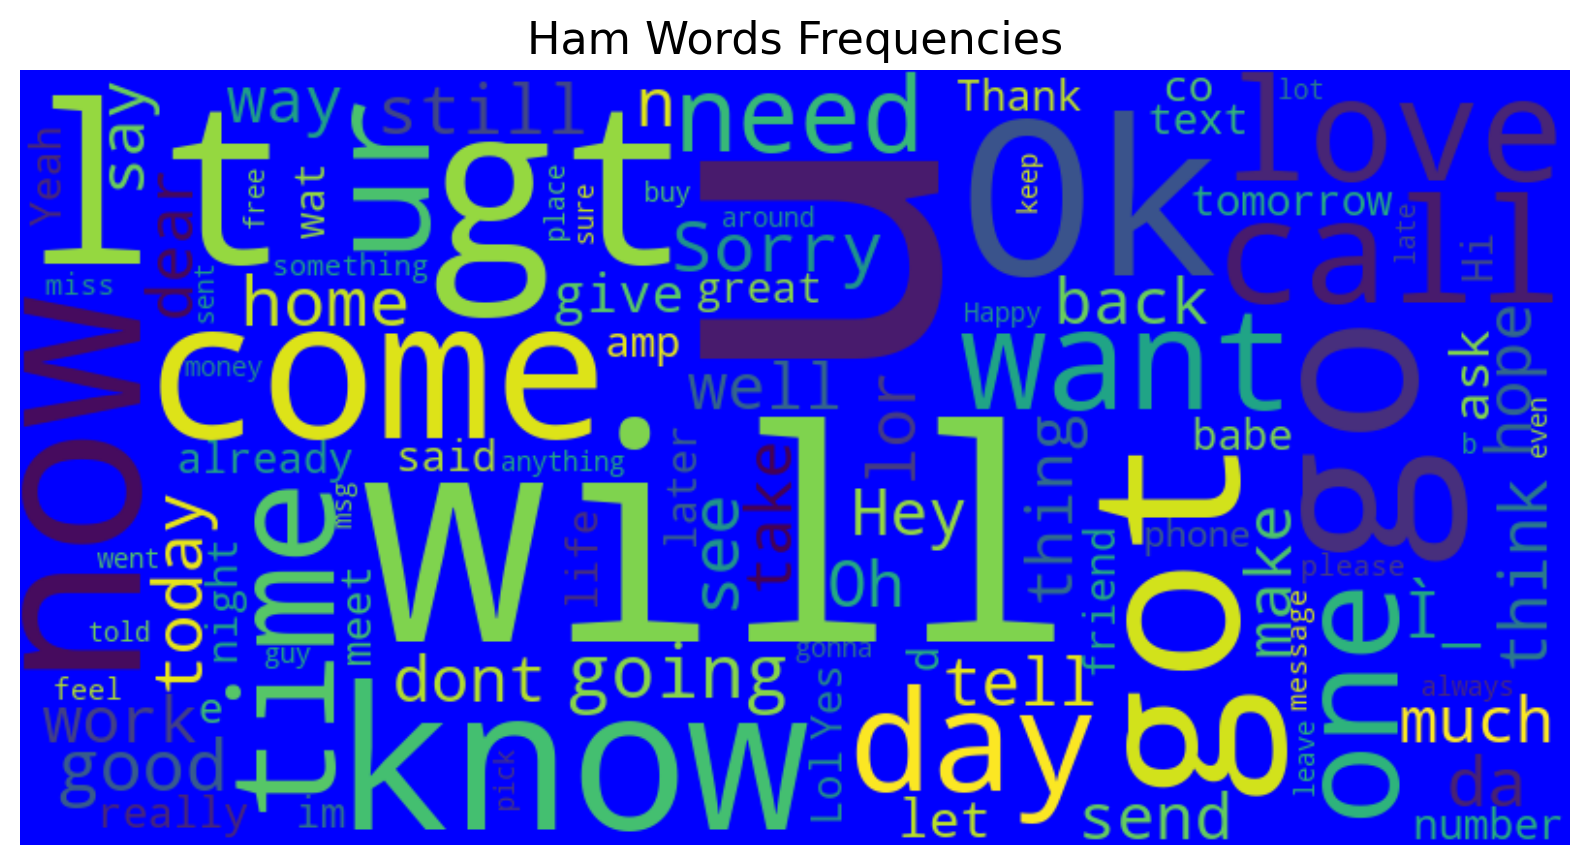

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
279/279 [==============================] - 3369s 12s/step - loss: 0.1182 - accuracy: 0.9663 - val_loss: 0.0436 - val_accuracy: 0.9946
Epoch 2/2
70/70 [==============================] - 231s 3s/step
(1115,)
(1115,)
Confusion Matrix:
[[957   8]
 [  4 146]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       965
           1       0.95      0.97      0.96       150

    accuracy                           0.99      1115
   macro avg       0.97      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



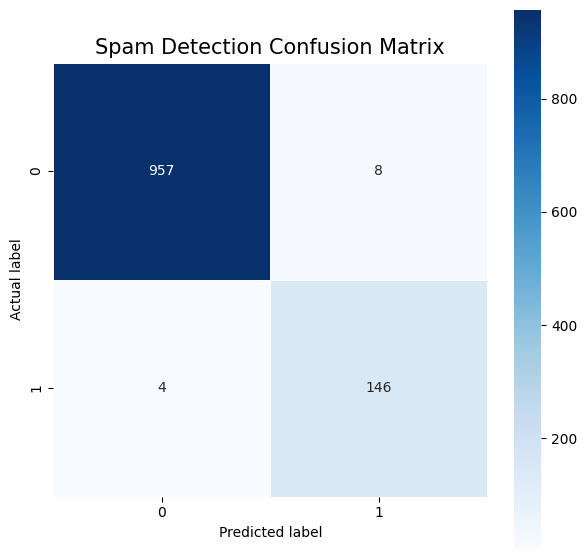

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       965
           1       0.95      0.97      0.96       150

    accuracy                           0.99      1115
   macro avg       0.97      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [6]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import re
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

df = pd.read_csv("C:/Users/serda/OneDrive/Bureau/Online Education/Certification/Spam_Detector/spam.csv", encoding='ISO-8859-1')

df.head()

df.info()

df=df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)

df=df.rename(columns={ 'v1':'label', 'v2':'text'})

df.label=df.label.map( {'ham':0, 'spam':1})

"""**spam is for 1, not spam is a 0**"""



"""**cleaning the text**

def clean_text(text):
  text=re.sub (r'\W+', ' ', text)
  text=re.sub (r' \d+', '', text)
  text= text=text.lower()
  return text

df['text']=df.text.apply(clean_text)

*We will not use any cleaning method nor lemmatize the text. Because lemmatize and cleaning like += and digits as  telephone numbers may cause loss of meaning . We will work on the raw text*
"""

df

spam_corpus= ' '.join(df['text'])

spam_corpus

"""**to compare ham/spam/all textes" subplots**"""

spammed_corpus = ' '.join(df[df['label'] == 1]['text'])
spammed_words = WordCloud( width= 800, height = 400, 
                      margin= 3, prefer_horizontal=0.6,  
                      max_words = 100,
                      min_font_size= 10, 
                      background_color='yellow', contour_width = 3, 
                      contour_color='black').generate(spammed_corpus)

hammed_corpus = ' '.join(df[df['label'] == 0]['text'])
hammed_words = WordCloud(width= 800, height = 400, 
                      margin= 3, prefer_horizontal=0.6,  
                      max_words = 100,
                      min_font_size= 10, 
                      background_color='blue', contour_width = 3, 
                      contour_color='black').generate(hammed_corpus)

grand_corpus = ' '.join(df['text'])
all_corpus= WordCloud(width= 800, height = 400, 
                      margin= 3, prefer_horizontal=0.6,  
                      max_words = 100,
                      min_font_size= 10, 
                      background_color='green', contour_width = 3, 
                      contour_color='black').generate(grand_corpus)

fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=200)

axs[0, 0].imshow(spammed_words, interpolation='bilinear')
axs[0, 0].axis("off")
axs[0, 0].set_title('Spam Words Frequencies\n(Special characters & numbers included)', fontsize=16)

axs[0, 1].imshow(hammed_words, interpolation='bilinear')
axs[0, 1].axis("off")
axs[0, 1].set_title('Ham Words Frequencies', fontsize=16)

axs[1, 0].imshow(all_corpus, interpolation='bilinear')
axs[1, 0].axis("off")
axs[1, 0].set_title('All Words Frequencies', fontsize=16)

axs[1, 1].axis('off')

plt.tight_layout()
plt.show()



"""**too see ham and spam in bigger format to analyze and detect** """

plt.figure(figsize=(10, 6), dpi=200)
plt.imshow(spammed_words, interpolation='bilinear')
plt.axis("off")
plt.title('Spam Words Frequencies\n(Special characters & numbers included)', fontsize=16)
plt.show()

plt.figure(figsize=(10, 6), dpi=200)
plt.imshow(hammed_words, interpolation='bilinear')
plt.axis("off")
plt.title('Ham Words Frequencies', fontsize=16)
plt.show()

"""We remark that some words such as free, message, call, urgent, guaranteed, valid 12hrs are tyupically spam messages and we find them in the wordcloud visualisations

##**Model**

**Bert Model is choosen as base model** // and 
**transformer library from Hugging Face**
"""

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#bert-base-uncased smaller version of the base BERT model, 
#trained on uncased (lowercased) English text
#has 12 Transformer layers, 12 attention heads, and 110 million parameters."

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

input_ids = tokenizer(df['text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='tf')
labels = df['label'].values

labels

#train test split / in the context train Validation split

X_train, X_val, y_train, y_val = train_test_split(input_ids['input_ids'].numpy(), labels, random_state=42, test_size=0.2)
### input_ids python needs it in numpy 
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08) #2e-5 is a convenitional rate
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.fit(train_dataset.shuffle(1000).batch(16), epochs=2, batch_size=16, validation_data=validation_dataset.batch(16))

model.evaluate(validation_dataset.batch(16))



# Assuming model is your trained model and val_dataset is your validation data.
predictions = model.predict(validation_dataset.batch(16))

logits = predictions.logits

probabilities = tf.nn.softmax(logits, axis=-1)

predicted_labels = tf.argmax(probabilities, axis=-1)

predicted_labels = predicted_labels.numpy()

print(y_val.shape)
print(predicted_labels.shape)



cm = confusion_matrix(y_val, predicted_labels)
print("Confusion Matrix:")
print(cm)

cr = classification_report(y_val, predicted_labels)
print("Classification Report:")
print(cr)

plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Spam Detection Confusion Matrix', size = 15);
plt.show()

# We can also print the classification report
print(classification_report(y_val, predicted_labels))